In [1]:
!pip install keras==2.12.0

In [2]:
import pandas as pd
import csv
from math import radians, sin, cos, sqrt, atan2
from datetime import datetime
import chardet
import os
import re
import copy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV, KFold
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

In [3]:
# find data's encoding

def get_encoding(colab_path):
  with open(colab_path, 'rb') as f:
    result = chardet.detect(f.read())
    return result['encoding']


In [4]:
# find aerial distance between two coordinates

def get_aerial_dist(lat1, lon1, lat2, lon2): # haversine formula - shortest distance between two points on the surface of a sphere
  lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2]) # degrees to radians

  dlat = lat2 - lat1
  dlon = lon2 - lon1
  a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  radius = 6371.0 # radius of the earth in km
  distance = radius * c

  return round(distance, 2) # in km


In [5]:
# preproccesing model data

def convert_to_date(date_str):
  try:
    return datetime.strptime(date_str, '%Y-%m-%d').strftime('%d/%m/%Y')

  except ValueError:
    try:
      return datetime.strptime(date_str, '%d/%m/%Y').strftime('%d/%m/%Y')

    except ValueError:
      return None # or any default value or action

given_data_df = pd.read_csv("/content/לטעינה - נתונים למודל.csv", encoding = get_encoding("/content/לטעינה - נתונים למודל.csv"))
given_data_df.drop(columns = ['season', 'emergence_date', 'batzal_date', 'f_to_m_date', 'dmg_from_mp', 'fiber_yield'], inplace = True)
given_data_df.dropna(subset = ['raw_yield'], how = 'any', inplace = True) # keep records with a non-null y value

# filter rows where value changed after conversion to int. compares the original float value with the converted integer value.
# if equal - the float value was already a whole number
given_data_df['raw_yield'] = given_data_df['raw_yield'].astype(int)
model_df = given_data_df[given_data_df['raw_yield'].astype(float) == given_data_df['raw_yield']]
given_data_df['sowing_date'] = given_data_df['sowing_date'].apply(convert_to_date)
given_data_df = given_data_df.dropna(subset = ['sowing_date'])
given_data_df['sowing_date'] = pd.to_datetime(given_data_df['sowing_date'], format = '%d/%m/%Y')

min_sowing_year = given_data_df['sowing_date'].dt.year.min()
max_sowing_year = given_data_df['sowing_date'].dt.year.max()
given_data_df.head(3)


,meshek,sowing_date,raw_yield
0,אגודת הפלחה,2023-04-26,609
1,אגודת הפלחה,2023-04-26,582
2,אגודת הפלחה,2023-04-25,555


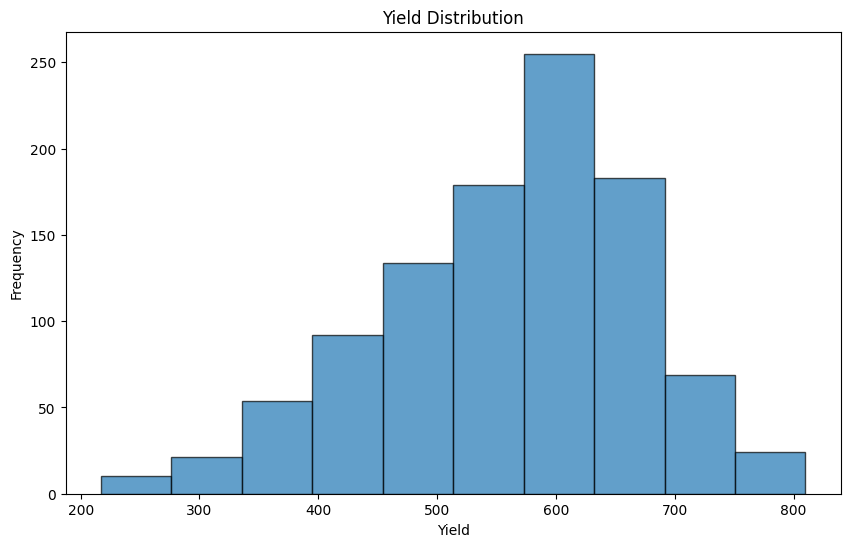

In [6]:
# exploring y distirubtion

num_bins = 10
counts, bin_edges = np.histogram(given_data_df['raw_yield'], bins=num_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
hist_df = pd.DataFrame({'bin_center': bin_centers, 'count': counts})

plt.figure(figsize = (10, 6))
plt.bar(hist_df['bin_center'], hist_df['count'], width = bin_edges[1] - bin_edges[0], edgecolor = 'k', alpha = 0.7)
plt.title('Yield Distribution')
plt.xlabel('Yield')
plt.ylabel('Frequency')
plt.show()


In [7]:
# exploring rain stations

rain_stations_loactions_df = pd.read_csv("/content/לטעינה - מיקומים ושנים של תחנות גשם.csv", encoding = get_encoding("/content/לטעינה - מיקומים ושנים של תחנות גשם.csv"))
rain_stations_loactions_df['station'].nunique()


1325

In [8]:
# exploring temp stations

temp_stations_loactions_df = pd.read_csv("/content/לטעינה - מיקומים ושנים של תחנות טמפ.csv", encoding = get_encoding("/content/לטעינה - מיקומים ושנים של תחנות טמפ.csv"))
temp_stations_loactions_df['station'].nunique()


204

In [9]:
# preprocessing rain stations data. filtering stations that are still operating or that were shut down after the min year of the data

#rain_stations_loactions_df = pd.read_csv("/content/לטעינה - מיקומים ושנים של תחנות גשם.csv", encoding = get_encoding("/content/לטעינה - מיקומים ושנים של תחנות גשם.csv"))
rain_stations_loactions_df = rain_stations_loactions_df[~rain_stations_loactions_df['station'].str.contains('הראל')] # a station i know that will be chosen as a close station but has no data
rain_stations_loactions_df.dropna(subset = ['station'], how = 'any', inplace = True)

rain_stations_loactions_df['closing_date'] = pd.to_datetime(rain_stations_loactions_df['closing_date'], format = '%d/%m/%Y', errors = 'coerce')
rain_stations_loactions_df = rain_stations_loactions_df.loc[(rain_stations_loactions_df['closing_date'] > datetime.strptime(f'01/01/{min_sowing_year}', '%d/%m/%Y')) # min year
                                                  | pd.isna(rain_stations_loactions_df['closing_date'])]

deg_cols = ['E', 'N']
for col_name in deg_cols:
  for index, value in rain_stations_loactions_df[col_name].items():
    if pd.notnull(value):
      rain_stations_loactions_df.at[index, col_name] = value[:-1] # trim degree char

rain_stations_loactions_df['E'] = pd.to_numeric(rain_stations_loactions_df['E'])
rain_stations_loactions_df['N'] = pd.to_numeric(rain_stations_loactions_df['N'])


<ipython-input-9-1361343b5c49>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rain_stations_loactions_df.dropna(subset = ['station'], how = 'any', inplace = True)
<ipython-input-9-1361343b5c49>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rain_stations_loactions_df['closing_date'] = pd.to_datetime(rain_stations_loactions_df['closing_date'], format = '%d/%m/%Y', errors = 'coerce')


In [10]:
# preprocessing mesheks

mesheks_loactions_df = pd.read_csv("/content/לטעינה - מיקומים ושנים של משקים.csv", encoding = get_encoding("/content/לטעינה - מיקומים ושנים של משקים.csv")) # each record is a combination of meshek and year
mesheks_loactions_df['E'] = pd.to_numeric(mesheks_loactions_df['E'])
mesheks_loactions_df['N'] = pd.to_numeric(mesheks_loactions_df['N'])


In [11]:
# find closest rain station to meshek

closest_rain_stations = {}
for i, meshek_record in mesheks_loactions_df.iterrows():
  if meshek_record['meshek'] not in closest_rain_stations: # make sure to check only for new stations
    shortest_distance = 100000
    mesheks_relevant_years = []

    for i2, meshek_record_y in mesheks_loactions_df.iterrows(): # get all years in which data was gathered in this meshek
      if meshek_record_y['meshek'] == meshek_record['meshek'] and meshek_record_y['season'] not in mesheks_relevant_years:
        mesheks_relevant_years.append(meshek_record_y['season'])

    max_meshek_year = max(mesheks_relevant_years)
    for i3, station_record in rain_stations_loactions_df.iterrows():
      if pd.isna(station_record['closing_date']) | ((pd.to_datetime(station_record['closing_date'], format = '%d/%m/%Y').year > max_meshek_year)): # if station data is relevant to this meshek (by operation timeframe)
        this_distance = get_aerial_dist(meshek_record['N'], meshek_record['E'], station_record['N'], station_record['E'])
        if this_distance < shortest_distance:
          shortest_distance = this_distance
          closest_station_name = station_record['station']

  closest_rain_stations[meshek_record['meshek']] = [closest_station_name, shortest_distance]

closest_rain_stations = pd.DataFrame(closest_rain_stations.values(), columns = ['station', 'distance'], index = closest_rain_stations.keys())
closest_rain_stations.reset_index(inplace = True)
closest_rain_stations.rename(columns = {'index': 'meshek', 'station':'rain_station'}, inplace = True)
#closest_rain_stations.to_excel('פלט - מרחקי תחנות גשם ממשקים.xlsx', index_label = 'meshek') # saved in colab's memory


In [12]:
closest_rain_stations.head(5)

,meshek,rain_station,distance
0,אבן ספיר,צובה,4.37
1,אורה,צובה,4.29
2,תעוז,נחשון מאוישת,3.40
3,תרום,צרעה,3.46
4,בית ניר,בית ניר,1.93


In [13]:
# preprocessing temp stations data. filtering stations that were open since before the max year

#temp_stations_loactions_df = pd.read_csv("/content/לטעינה - מיקומים ושנים של תחנות טמפ.csv", encoding = get_encoding("/content/לטעינה - מיקומים ושנים של תחנות טמפ.csv"))
temp_stations_loactions_df = temp_stations_loactions_df[~temp_stations_loactions_df['station'].str.contains('עין\xa0החורש')] # a station i know that will be chosen as a close station but has no data
temp_stations_loactions_df = temp_stations_loactions_df[~temp_stations_loactions_df['station'].str.contains('גת\xa0מאוישת')] # a station i know that will be chosen as a close station but has no data
temp_stations_loactions_df = temp_stations_loactions_df[~temp_stations_loactions_df['station'].str.contains('אילון\xa0מאוישת')] # a station i know that will be chosen as a close station but has no data
temp_stations_loactions_df.dropna(subset = ['station'], how = 'any', inplace = True)

temp_stations_loactions_df['closing_date'] = pd.to_datetime(temp_stations_loactions_df['closing_date'], format = '%d/%m/%Y', errors = 'coerce')
temp_stations_loactions_df = temp_stations_loactions_df.loc[(temp_stations_loactions_df['closing_date'] > datetime.strptime(f'01/01/{min_sowing_year}', '%d/%m/%Y')) # min year
                                                  | pd.isna(temp_stations_loactions_df['closing_date'])]

deg_cols = ['E', 'N']
for col_name in deg_cols:
  for index, value in temp_stations_loactions_df[col_name].items():
    if pd.notnull(value):
      temp_stations_loactions_df.at[index, col_name] = value[:-1] # trim degree char

temp_stations_loactions_df['E'] = pd.to_numeric(temp_stations_loactions_df['E'])
temp_stations_loactions_df['N'] = pd.to_numeric(temp_stations_loactions_df['N'])


In [14]:
# find closest temp station to meshek

closest_temp_stations = {}
for i, meshek_record in mesheks_loactions_df.iterrows():
  if meshek_record['meshek'] not in closest_temp_stations: # make sure to check only for new stations
    shortest_distance = 100000
    mesheks_relevant_years = []

    for i2, meshek_record_y in mesheks_loactions_df.iterrows(): # get all years in which data was gathered in this meshek
      if meshek_record_y['meshek'] == meshek_record['meshek'] and meshek_record_y['season'] not in mesheks_relevant_years:
        mesheks_relevant_years.append(meshek_record_y['season'])

    max_meshek_year = max(mesheks_relevant_years)
    for i3, station_record in temp_stations_loactions_df.iterrows():
      if pd.isna(station_record['closing_date']) | ((pd.to_datetime(station_record['closing_date'], format = '%d/%m/%Y').year > max_meshek_year)): # if station data is relevant to this meshek (by operation timeframe)
        this_distance = get_aerial_dist(meshek_record['N'], meshek_record['E'], station_record['N'], station_record['E'])
        if this_distance < shortest_distance:
          shortest_distance = this_distance
          closest_station_name = station_record['station']

  closest_temp_stations[meshek_record['meshek']] = [closest_station_name, shortest_distance]

closest_temp_stations = pd.DataFrame(closest_temp_stations.values(), columns = ['station', 'distance'], index = closest_temp_stations.keys())
closest_temp_stations.reset_index(inplace = True)
closest_temp_stations.rename(columns = {'index': 'meshek', 'station':'temp_station'}, inplace = True)
#closest_temp_stations.to_excel('פלט - מרחקי תחנות טמפ ממשקים.xlsx', index_label = 'meshek') # saved in colab's memory


In [15]:
model_df = given_data_df.merge(closest_rain_stations[['meshek', 'rain_station']], on = ['meshek'], how = 'inner')
model_df = model_df.merge(closest_temp_stations[['meshek', 'temp_station']], on = ['meshek'], how = 'inner')
model_df.head(3)


,meshek,sowing_date,raw_yield,rain_station,temp_station
0,צבר קמה,2023-03-30,557,רבדים,חפץ חיים
1,צבר קמה,2023-03-28,568,רבדים,חפץ חיים
2,צבר קמה,2023-03-28,665,רבדים,חפץ חיים


In [16]:
# aggregate relevant rain stations by time scope for fetching data

print('rain stations\' data:\n')
relevant_rain_stations_data = copy.deepcopy(model_df)
relevant_rain_stations_data.drop(columns = ['raw_yield', 'temp_station'], inplace = True)
relevant_rain_stations_data['sowing_date'] = pd.to_datetime(relevant_rain_stations_data['sowing_date'])
relevant_rain_stations_data['year'] = relevant_rain_stations_data['sowing_date'].dt.year
grouped_df = relevant_rain_stations_data.groupby('rain_station')['year'].agg(['min', 'max']).reset_index()
grouped_df['operational_years'] = grouped_df.apply(lambda x: f"{x['min']}-{x['max']}", axis = 1)
rain_stations_by_range = grouped_df.groupby('operational_years')['rain_station'].apply(', '.join).reset_index()
print(rain_stations_by_range)
print('\nfor each station, fetching data of: january 1st of the year of the sowing date,\nand up until 30.6 of the same year')


rain stations' data:

   operational_years                               rain_station
0          2015-2015  אושה, כפר מסריק, נחשון מאוישת, צובה, צרעה
1          2015-2016          בית ניר, גת מאוישת, חדרה תחנת הכח
2          2015-2017                                משואות יצחק
3          2015-2018                כפר ביל"ו, עין החורש מאוישת
4          2015-2020       גבעת ברנר, כפר הרואה, כפר מנחם, קדמה
5          2015-2022                         חולדה, ניצנים קבוץ
6          2015-2023                             גן שלמה, רבדים
7          2016-2016                            נתיב הלה מאוישת
8          2016-2018                               אילון מאוישת
9          2016-2020                                  עין צורים
10         2016-2022                                   בני דרום
11         2016-2023                  בית חלקיה, יסודות, שעלבים
12         2018-2018                                נגבה מאוישת
13         2020-2020                                 גן השומרון

for each station,

In [17]:
# # grouped df to excel to show in report

# output_file = 'rain_stations_by_range.xlsx'
# rain_stations_by_range.to_excel(output_file, index = False)


In [18]:
# aggregate relevant temp stations by time scope for fetching data

print('temp stations\' data:\n')
relevant_temp_stations_data = copy.deepcopy(model_df)
relevant_temp_stations_data.drop(columns = ['raw_yield', 'rain_station'], inplace = True)
relevant_temp_stations_data['sowing_date'] = pd.to_datetime(relevant_temp_stations_data['sowing_date'])
relevant_temp_stations_data['year'] = relevant_temp_stations_data['sowing_date'].dt.year
grouped_df = relevant_temp_stations_data.groupby('temp_station')['year'].agg(['min', 'max']).reset_index()
grouped_df['operational_years'] = grouped_df.apply(lambda x: f"{x['min']}-{x['max']}", axis = 1)
temp_stations_by_range = grouped_df.groupby('operational_years')['temp_station'].apply(', '.join).reset_index()
print(temp_stations_by_range)
print('\nfor each station, fetching data of: january 1st of the year of the sowing date,\nand up until 30.6 of the same year')


temp stations' data:

  operational_years                 temp_station
0         2015-2015    אפק, חיפה בתי זיקוק, צובה
1         2015-2020           גת, חדרה נמל, נגבה
2         2015-2022                         ניצן
3         2015-2023  חפץ חיים, נחשון, קבוצת יבנה
4         2016-2016                     נתיב הלה
5         2016-2018                        אילון

for each station, fetching data of: january 1st of the year of the sowing date,
and up until 30.6 of the same year


In [19]:
# # grouped df to excel to show in report

# output_file = 'temp_stations_by_range.xlsx'
# temp_stations_by_range.to_excel(output_file, index = False)


In [20]:
# rain data

def clean_station_name(station):
  cleaned_station = re.sub(r'[0-9\-/]', '', station)
  return cleaned_station.strip()

rain_df = pd.read_csv("/content/לטעינה - נתוני גשם.csv", encoding = get_encoding("/content/לטעינה - נתוני גשם.csv"))
rain_df['station'] = rain_df['station'].apply(clean_station_name)
rain_df.rename(columns = {'station': 'rain_station'}, inplace = True)
rain_df['date'] = pd.to_datetime(rain_df['date'], format = '%d/%m/%Y')
rain_df.head(3)


,rain_station,date,rainfall
0,כפר מסריק,2015-01-01,2.4
1,אושה,2015-01-01,3.6
2,חדרה תחנת הכח,2015-01-01,2.5


In [21]:
# temp data

temp_df = pd.read_csv("/content/לטעינה - נתוני טמפ.csv", encoding = get_encoding("/content/לטעינה - נתוני טמפ.csv"))
temp_df = temp_df.dropna()
temp_df['station'] = temp_df['station'].apply(clean_station_name)
temp_df.rename(columns = {'station': 'temp_station'}, inplace = True)
temp_df['date'] = pd.to_datetime(temp_df['date'], format = '%d/%m/%Y')
temp_df.head(3)


,temp_station,date,max_temp,min_temp
0,אפק,2015-01-01,21.7,10.3
1,חיפה בתי זיקוק,2015-01-01,23.3,10.0
2,צובה,2015-01-01,14.9,7.6


In [22]:
# setting station indexes to be used later

def clean_station_names(station_col):
  station_col = station_col.str.replace(' ', '')
  station_col = station_col.str.replace('\xa0', '')
  return station_col

# remove spaces from strings in relevant columns
rain_df['rain_station'] = clean_station_names(rain_df['rain_station'])
temp_df['temp_station'] = clean_station_names(temp_df['temp_station'])
model_df['rain_station'] = clean_station_names(model_df['rain_station'])
model_df['temp_station'] = clean_station_names(model_df['temp_station'])

# setting index based on stations
unique_stations = pd.Index(list(set(rain_df['rain_station'].unique()) | set(temp_df['temp_station'].unique())))
station_index = pd.Series(range(len(unique_stations)), index = unique_stations)

# adding index based on station
rain_df['rain_station_index'] = rain_df['rain_station'].map(station_index)
temp_df['temp_station_index'] = temp_df['temp_station'].map(station_index)


In [23]:
# add index columns to model_df based on dictionary

model_df['rain_station_index'] = model_df['rain_station'].map(station_index)
model_df['temp_station_index'] = model_df['temp_station'].map(station_index)

model_df['sowing_date'] = pd.to_datetime(model_df['sowing_date'], format = '%d/%m/%Y')
model_df.dropna(subset = ['rain_station_index', 'temp_station_index'], inplace = True)
model_df.head(3)


,meshek,sowing_date,raw_yield,rain_station,temp_station,rain_station_index,temp_station_index
0,צבר קמה,2023-03-30,557,רבדים,חפץחיים,9.0,19.0
1,צבר קמה,2023-03-28,568,רבדים,חפץחיים,9.0,19.0
2,צבר קמה,2023-03-28,665,רבדים,חפץחיים,9.0,19.0


In [24]:
model_df.shape

(978, 7)

In [25]:
def rename_week_columns(columns, text):
  numeric_columns = []
  non_numeric_columns = []

  # iterate through each column name
  for col in columns:
    col_str = str(col)
    # define a regular expression pattern to match numeric values
    pattern = r'^-?\d+$'
    # check if the column name matches the numeric pattern
    if bool(re.match(pattern, col_str)):
      numeric_columns.append(int(col_str)) # convert numeric column names to integers
    else:
      non_numeric_columns.append(col) # store non-numeric column names

  # merge numeric and non-numeric columns, ensuring non-numeric columns appear first
  renamed_columns = non_numeric_columns + [f"{text}_{num}" for num in numeric_columns]

  return renamed_columns

In [26]:
def sort_columns_by_week(columns):
  numeric_part = []
  non_numeric_columns = []
  for col in columns:
    col_str = str(col)
    pattern = r'^-?\d+$'
    if bool(re.match(pattern, col_str)):
      numeric_part.append(int(col_str))
    else:
      non_numeric_columns.append(col) # store non-numeric column names
  sorted_numeric_columns = sorted(numeric_part)
  # merge numeric and non-numeric columns, ensuring non-numeric columns appear first
  sorted_columns = non_numeric_columns + sorted_numeric_columns

  return sorted_columns


In [27]:
print(model_df['sowing_date'].min())
print(model_df['sowing_date'].max())

2015-03-06 00:00:00
2023-03-30 00:00:00


In [28]:
model_df['find_min'] = model_df['sowing_date'].dt.strftime('%m-%d')
min_month_day = model_df['find_min'].min()
min_sowing_date = '2015-' + min_month_day
min_sowing_date = datetime.strptime(min_sowing_date, '%Y-%m-%d')

max_month_day = model_df['find_min'].max()
max_sowing_date = '2022-' + max_month_day
max_sowing_date = datetime.strptime(max_sowing_date, '%Y-%m-%d')

model_df.drop(columns = ['find_min'], inplace=True)


In [29]:
# get minmax num of weeks, to suit all records

jan_1 = datetime(min_sowing_date.year, 1, 1)
num_days_jan_to_sowing = (min_sowing_date - jan_1).days
num_weeks_jan_to_sowing = num_days_jan_to_sowing // 7
if num_days_jan_to_sowing % 7 != 0:
  num_weeks_jan_to_sowing += 1
num_weeks_jan_to_sowing -= 1 # to care care of edges

jun_30 = datetime(max_sowing_date.year, 6, 30)
num_days_sowing_to_jun = (jun_30 - max_sowing_date).days
num_weeks_sowing_to_jun = num_days_sowing_to_jun // 7
if num_days_sowing_to_jun % 7 != 0:
  num_weeks_sowing_to_jun += 1
num_weeks_sowing_to_jun -= 1 # to care care of edges

days_for_nine_weeks = num_weeks_jan_to_sowing * 7
days_for_eleven_weeks = num_weeks_sowing_to_jun * 7


In [30]:
aggregation_func = {'sum': sum, 'mean': np.mean}

In [31]:
def find_relevant_station_records_for_rain(rain_station_index): # filters station data to find dates that are within the time scope
  station_data = rain_df[rain_df['rain_station_index'] == rain_station_index]
  return station_data


In [32]:
# finding how much rain was measured by each station per each week in the time scope

def get_rainfall(measure, num_weeks_jan_to_sowing, num_weeks_sowing_to_jun):
  predefined_df_rain = pd.DataFrame()

  for i, row in model_df.iterrows():
    full_rain_df = find_relevant_station_records_for_rain(row['rain_station_index'])
    # full_rain_df = full_rain_df.copy()
    # print(full_rain_df)
    # keep records of rain dates of the sowing date's year
    reference_year = pd.to_datetime(row['sowing_date']).year
    full_rain_df = full_rain_df[full_rain_df['date'].dt.year == reference_year].copy()
    full_rain_df = full_rain_df[(full_rain_df['date'] <= pd.to_datetime(f'{reference_year}-06-30')) &
                                (full_rain_df['date'] >= pd.to_datetime(f'{reference_year}-01-01'))]

    # create a df with index as all dates between January 1st and June 30th of the reference year
    idx = pd.date_range(start=f'{reference_year}-01-01', end=f'{reference_year}-06-30')
    new_df = pd.DataFrame(index=idx)
    # merge new_df with full_rain_df to fill in the missing dates
    full_rain_df = pd.merge(new_df, full_rain_df, how='left', left_index = True, right_on = 'date')

    # fill NaN values in the 'rainfall' column with zeros
    full_rain_df['rainfall'].fillna(0, inplace = True)

    fill_methods = {
                'rain_station_index': row['rain_station_index'],
                'rain_station': row['rain_station']
    }
    full_rain_df.fillna(value = fill_methods, inplace = True)
    full_rain_df.reset_index(inplace = True, drop = True)

    # calculate week number to each date of rainfall
    # find dates that are outside of scope and cut them
    refer_date = pd.to_datetime(row['sowing_date']).replace(month = 1, day = 1)
    days_from_sowing_to_jan1 = (pd.to_datetime(row['sowing_date']) - refer_date).days
    days_from_sowing_to_eleven_weeks = days_from_sowing_to_jan1 + days_for_eleven_weeks
    number_rows_to_remove_from_jan1 = days_from_sowing_to_jan1 - days_for_nine_weeks
    full_rain_df = full_rain_df.iloc[number_rows_to_remove_from_jan1 : days_from_sowing_to_eleven_weeks]

    first_date = full_rain_df.iloc[0]['date']
    full_rain_df['year'] = full_rain_df['date'].dt.year # avoid SettingWithCopyWarning
    full_rain_df['reference_date'] = pd.to_datetime(row['sowing_date']).replace(month = first_date.month, day = first_date.day) # reference date is January 1st of the sowing year

    full_rain_df['days_since_reference'] = (full_rain_df['date'] - full_rain_df['reference_date']).dt.days
    full_rain_df['week_number'] = (full_rain_df['days_since_reference'] // 7)
    full_rain_df['week_number'] -= num_weeks_jan_to_sowing # shifting weeks numbering so that the sowing week is 0
    full_rain_df.drop(columns = ['year', 'reference_date', 'days_since_reference'], inplace = True) # resolve SettingWithCopyWarning

    measure_func = aggregation_func.get(measure)
    full_rain_df.drop(columns = ['date'], inplace = True)

    grouped_df = full_rain_df.groupby(['rain_station_index', 'week_number']).agg({'rainfall': lambda x: round(measure_func(x), 2)}).reset_index()
    grouped_df.rename(columns = {'rainfall': 'weekly_rain'}, inplace = True)

    pivot_df = grouped_df.pivot_table(index = 'rain_station_index', columns = 'week_number', values='weekly_rain')
    pivot_df.reset_index(inplace = True)
    #pivot_df = pivot_df.rename_axis(None, axis = 1)
    pivot_df['sowing_date'] = row['sowing_date']
    pivot_df['raw_yield'] = row['raw_yield']

    # sort columns by week number
    pivot_df = pivot_df.reindex(sort_columns_by_week(pivot_df.columns), axis = 1)

    # rename columns to rain_week
    pivot_df.columns = rename_week_columns(pivot_df.columns, 'rain')

    predefined_df_rain = pd.concat([predefined_df_rain, pivot_df], ignore_index = True)

  return predefined_df_rain


In [33]:
predefined_df_rain = get_rainfall('sum', num_weeks_jan_to_sowing, num_weeks_sowing_to_jun)
predefined_df_rain.head(3)


<ipython-input-32-223f04221cc4>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_rain_df['year'] = full_rain_df['date'].dt.year # avoid SettingWithCopyWarning
<ipython-input-32-223f04221cc4>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_rain_df['reference_date'] = pd.to_datetime(row['sowing_date']).replace(month = first_date.month, day = first_date.day) # reference date is January 1st of the sowing year
<ipython-input-32-223f04221cc4>:44: SettingWithCopyWarning: 
A value is trying to be set o

,rain_station_index,sowing_date,raw_yield,rain_-8,rain_-7,rain_-6,rain_-5,rain_-4,rain_-3,rain_-2,...,rain_0,rain_1,rain_2,rain_3,rain_4,rain_5,rain_6,rain_7,rain_8,rain_9
0,9.0,2023-03-30,557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.0,2023-03-28,568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.0,2023-03-28,665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
predefined_df_rain.shape

(978, 21)

In [35]:
def find_relevant_station_records_for_temp(temp_station_index): # filters station data to find dates that are within the time scope
  station_data = temp_df[temp_df['temp_station_index'] == temp_station_index]
  return station_data


In [36]:
# finding how much day degrees was measured by each station per each week in the time scope

def get_heat(measure, num_weeks_jan_to_sowing, num_weeks_sowing_to_jun):
  predefined_df_heat = pd.DataFrame()

  for i, row in model_df.iterrows():
    full_temp_df = find_relevant_station_records_for_temp(row['temp_station_index'])
    full_temp_df = full_temp_df.copy()
    full_temp_df.dropna(subset = ['max_temp', 'min_temp'], inplace = True)
    full_temp_df['heat'] = ((full_temp_df['max_temp'].apply(lambda x: max(x, 12)) - 12) + (full_temp_df['min_temp'].apply(lambda x: max(x, 12)) - 12)) / 2

    # keep records of dates of the sowing date's year
    reference_year = pd.to_datetime(row['sowing_date']).year

    full_temp_df = full_temp_df[full_temp_df['date'].dt.year == reference_year].copy()
    full_temp_df = full_temp_df[(full_temp_df['date'] <= pd.to_datetime(f'{reference_year}-06-30')) &
                                (full_temp_df['date'] >= pd.to_datetime(f'{reference_year}-01-01'))]

    # create a df with index as all dates between January 1st and June 30th of the reference year
    idx = pd.date_range(start=f'{reference_year}-01-01', end = f'{reference_year}-06-30')
    new_df = pd.DataFrame(index = idx)
    # merge new_df with full_rain_df to fill in the missing dates
    full_temp_df = pd.merge(new_df, full_temp_df, how = 'left', left_index = True, right_on = 'date')

    fill_methods = {
                'temp_station_index': row['temp_station_index'],
                'temp_station': row['temp_station']
    }
    full_temp_df.fillna(value = fill_methods, inplace = True)
    full_temp_df.reset_index(inplace = True, drop = True)

    # filling missing values by linear interpolation. begin with forward fill and then backward fill if needed
    columns_to_fill = ['max_temp', 'min_temp', 'heat']

    full_temp_df[columns_to_fill] = full_temp_df[columns_to_fill].ffill()
    if full_temp_df[columns_to_fill].isnull().any().any():
      full_temp_df[columns_to_fill] = full_temp_df[columns_to_fill].bfill()

    refer_date = pd.to_datetime(row['sowing_date']).replace(month = 1, day = 1)
    days_from_sowing_to_jan1 = (pd.to_datetime(row['sowing_date']) - refer_date).days
    days_from_sowing_to_eleven_weeks = days_from_sowing_to_jan1 + days_for_eleven_weeks
    number_rows_to_remove_from_jan1 = days_from_sowing_to_jan1 - days_for_nine_weeks

    full_temp_df = full_temp_df.iloc[number_rows_to_remove_from_jan1 : days_from_sowing_to_eleven_weeks]
    first_date = full_temp_df.iloc[0]['date']

    full_temp_df['year'] = full_temp_df['date'].dt.year # avoid SettingWithCopyWarning
    full_temp_df['reference_date'] = pd.to_datetime(row['sowing_date']).replace(month = first_date.month, day = first_date.day) # reference date is January 1st of the sowing year
    full_temp_df['days_since_reference'] = (full_temp_df['date'] - full_temp_df['reference_date']).dt.days # days between the record's temp date and the 1.1.year
    full_temp_df['week_number'] = (full_temp_df['days_since_reference'] // 7)
    full_temp_df['week_number'] -= num_weeks_jan_to_sowing # shifting weeks numbering so that the sowing week is 0. data is assumed to be only until 30.6

    #full_temp_df.drop(columns=['year', 'reference_date', 'days_since_reference', 'temp_station', 'date', 'max_temp', 'min_temp'], inplace = True) # resolve SettingWithCopyWarning
    full_temp_df.drop(columns=['year', 'reference_date', 'days_since_reference', 'temp_station', 'date', 'heat'], inplace = True) # resolve SettingWithCopyWarning
    measure_func = aggregation_func.get(measure)

    #grouped_df = full_temp_df.groupby(['temp_station_index', 'week_number']).agg({'heat': lambda x: round(measure_func(x), 2)}).reset_index()
    grouped_df = full_temp_df.groupby(['temp_station_index', 'week_number']).agg({
      #'heat': lambda x: round(measure_func(x), 2)#,
      'min_temp': lambda x: round(np.mean(x), 2),
      'max_temp': lambda x: round(np.mean(x), 2)
    }).reset_index()

    #pivot_df = grouped_df.pivot_table(index = 'temp_station_index', columns = 'week_number', values = 'heat')
    pivot_df = grouped_df.pivot_table(index = 'temp_station_index', columns = 'week_number', values = ['min_temp', 'max_temp'])
    #pivot_df = grouped_df.pivot_table(index = 'temp_station_index', columns='week_number', values = ['heat', 'min_temp', 'max_temp'])

    pivot_df.reset_index(inplace = True)
    #pivot_df = pivot_df.rename_axis(None, axis = 1)

    pivot_df['sowing_date'] = row['sowing_date']
    pivot_df['raw_yield'] = row['raw_yield']

    # sort columns by week number
    pivot_df = pivot_df.reindex(sort_columns_by_week(pivot_df.columns), axis = 1)

    # rename columns to heat_week
    #pivot_df.columns = rename_week_columns(pivot_df.columns, 'heat')
    pivot_df.columns = rename_week_columns(pivot_df.columns, 'min')
    pivot_df.columns = rename_week_columns(pivot_df.columns, 'max')

    predefined_df_heat = pd.concat([predefined_df_heat, pivot_df], ignore_index = True)

  return predefined_df_heat


In [37]:
predefined_df_heat = get_heat('sum', num_weeks_jan_to_sowing, num_weeks_sowing_to_jun)
predefined_df_heat.head(3)


<ipython-input-36-6b886ad6b9d9>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_temp_df['year'] = full_temp_df['date'].dt.year # avoid SettingWithCopyWarning
<ipython-input-36-6b886ad6b9d9>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_temp_df['reference_date'] = pd.to_datetime(row['sowing_date']).replace(month = first_date.month, day = first_date.day) # reference date is January 1st of the sowing year
<ipython-input-36-6b886ad6b9d9>:49: SettingWithCopyWarning: 
A value is trying to be set o

temp_station_index sowing_date raw_yield max_temp                       \
                                                 -8     -7     -6     -5   
0               19.0  2022-04-02       672    17.34  18.91  19.51  19.23   
1               19.0  2022-04-02       622    17.34  18.91  19.51  19.23   
2               19.0  2022-04-01       584    17.10  18.50  20.06  18.89   

                        ... min_temp                                           \
      -4     -3     -2  ...        0      1      2      3      4      5     6   
0  19.93  14.81  15.14  ...    12.79  10.00  12.24  14.23  16.44  11.49  14.5   
1  19.93  14.81  15.14  ...    12.79  10.00  12.24  14.23  16.44  11.49  14.5   
2  20.53  14.57  15.06  ...    11.56  11.41  11.87  14.19  15.63  11.94  14.5   

                        
       7      8      9  
0  15.96  16.63  16.77  
1  15.96  16.63  16.77  
2  15.50  16.74  16.17  

[3 rows x 39 columns]

In [38]:
# @@@@@@ Note: only for when using mix_temp and max_temp and NOT heat

predefined_df_heat.columns = [f"{col[0]}_{str(col[1]).replace('(', '').replace(')', '').replace(',', '_')}" for col in predefined_df_heat.columns]
predefined_df_heat.columns = [col[:-1] if col.startswith(('temp_station_index_', 'sowing_date_', 'raw_yield_')) else col for col in predefined_df_heat.columns]


In [39]:
# merging dfs and averaging raw_yield values for records that have same X

merged_df = model_df.merge(predefined_df_rain, on = ['sowing_date', 'rain_station_index', 'raw_yield'], how = 'inner')
merged_df = merged_df.drop_duplicates()

merged_df = merged_df.merge(predefined_df_heat, on = ['sowing_date', 'temp_station_index', 'raw_yield'], how = 'inner')
merged_df = merged_df.drop_duplicates()

merged_df.drop(columns = ['meshek', 'sowing_date', 'rain_station', 'temp_station', 'rain_station_index', 'temp_station_index'], inplace = True)
# merged_df.drop(columns = ['rain_9'], inplace = True) # witnessed that contains mostly 0's

grouped_df = merged_df.groupby(merged_df.columns.drop('raw_yield').tolist()).agg({'raw_yield': 'mean'}).reset_index()
grouped_df['raw_yield'] = np.floor(grouped_df['raw_yield']).astype(int)
final_model_df = grouped_df.dropna()

# retain records where at least one of the rain-related columns has a non-zero value
columns_list = ['rain_{}'.format(i) for i in range(-8, 9)]
final_model_df = final_model_df[~(final_model_df[columns_list] == 0.0).all(axis = 1)]
final_model_df.head(3)


,rain_-8,rain_-7,rain_-6,rain_-5,rain_-4,rain_-3,rain_-2,rain_-1,rain_0,rain_1,...,min_temp_1,min_temp_2,min_temp_3,min_temp_4,min_temp_5,min_temp_6,min_temp_7,min_temp_8,min_temp_9,raw_yield
11,0.0,0.0,0.0,0.0,53.3,0.0,0.1,1.0,2.2,0.0,...,9.73,8.53,10.06,12.16,10.53,13.60,12.50,14.99,15.36,502
12,0.0,0.0,0.0,0.0,53.3,0.0,1.1,0.0,2.2,0.0,...,9.70,8.59,10.60,12.31,10.43,13.37,12.83,14.93,16.11,513
13,0.0,0.0,0.0,2.8,50.5,0.0,1.1,0.0,2.2,0.0,...,9.40,8.77,10.50,12.63,11.10,12.46,13.66,14.74,16.60,483


In [40]:
print(final_model_df.shape)


(294, 55)


In [41]:
final_model_df.columns

Index(['rain_-8', 'rain_-7', 'rain_-6', 'rain_-5', 'rain_-4', 'rain_-3',
       'rain_-2', 'rain_-1', 'rain_0', 'rain_1', 'rain_2', 'rain_3', 'rain_4',
       'rain_5', 'rain_6', 'rain_7', 'rain_8', 'rain_9', 'max_temp_-8',
       'max_temp_-7', 'max_temp_-6', 'max_temp_-5', 'max_temp_-4',
       'max_temp_-3', 'max_temp_-2', 'max_temp_-1', 'max_temp_0', 'max_temp_1',
       'max_temp_2', 'max_temp_3', 'max_temp_4', 'max_temp_5', 'max_temp_6',
       'max_temp_7', 'max_temp_8', 'max_temp_9', 'min_temp_-8', 'min_temp_-7',
       'min_temp_-6', 'min_temp_-5', 'min_temp_-4', 'min_temp_-3',
       'min_temp_-2', 'min_temp_-1', 'min_temp_0', 'min_temp_1', 'min_temp_2',
       'min_temp_3', 'min_temp_4', 'min_temp_5', 'min_temp_6', 'min_temp_7',
       'min_temp_8', 'min_temp_9', 'raw_yield'],
      dtype='object')

In [42]:
# remove correlated columns

# calculate Pearson correlation coefficient
correlation_matrix = final_model_df.corr()
threshold = 0.75

# find columns with high correlation
high_correlation_cols = set()  # column names to be dropped
for i in range(len(correlation_matrix.columns)):
  for j in range(i):
    if abs(correlation_matrix.iloc[i, j]) > threshold:
      colname = correlation_matrix.columns[i]
      high_correlation_cols.add(colname)

final_model_df = final_model_df.drop(columns = high_correlation_cols)


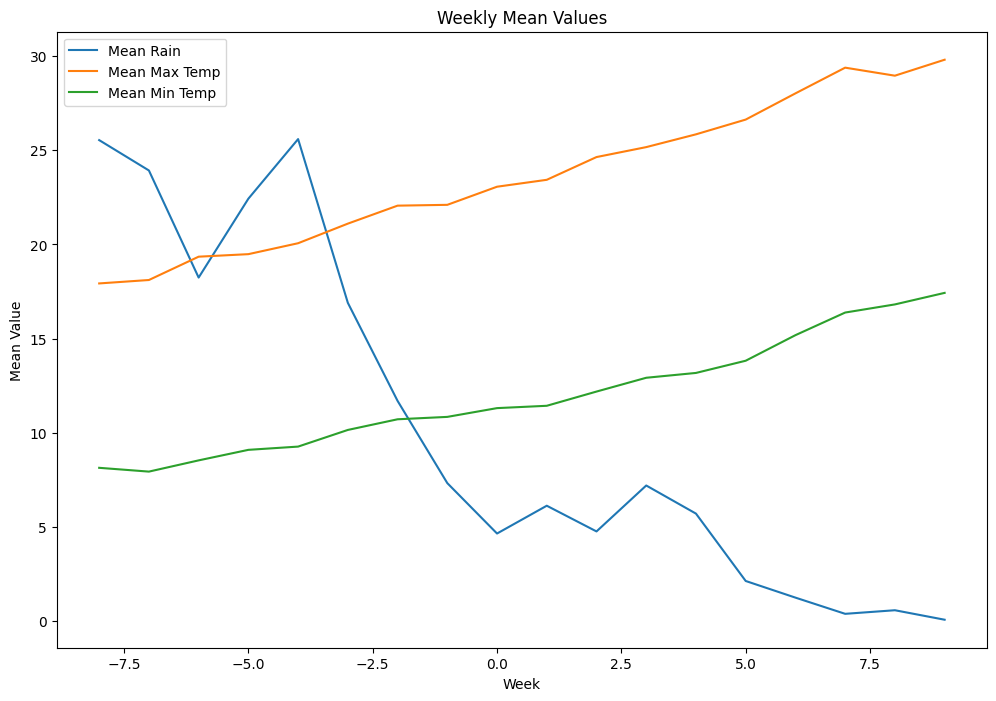

In [43]:
# grouped data weekly feature analysis

# defining columns for different feature types
rain_cols = [col for col in final_model_df.columns if 'rain' in col]
max_temp_cols = [col for col in final_model_df.columns if 'max_temp' in col]
min_temp_cols = [col for col in final_model_df.columns if 'min_temp' in col]

weeks = list(range(-8, 10))

# aggregate data by week
rain_by_week = {week: final_model_df[f'rain_{week}'].mean() for week in weeks}
max_temp_by_week = {week: final_model_df[f'max_temp_{week}'].mean() for week in weeks}
min_temp_by_week = {week: final_model_df[f'min_temp_{week}'].mean() for week in weeks}

# df for plotting
aggregated_df = pd.DataFrame({
    'week': weeks,
    'mean_rain': [rain_by_week[week] for week in weeks],
    'mean_max_temp': [max_temp_by_week[week] for week in weeks],
    'mean_min_temp': [min_temp_by_week[week] for week in weeks]
})

plt.figure(figsize = (12, 8))
sns.lineplot(data = aggregated_df, x = 'week', y = 'mean_rain', label = 'Mean Rain')
sns.lineplot(data = aggregated_df, x = 'week', y = 'mean_max_temp', label = 'Mean Max Temp')
sns.lineplot(data = aggregated_df, x = 'week', y = 'mean_min_temp', label = 'Mean Min Temp')
plt.xlabel('Week')
plt.ylabel('Mean Value')
plt.title('Weekly Mean Values')
plt.legend()
plt.show()


In [44]:
# removing sprase column

final_model_df.drop(columns = ['rain_9'], inplace = True) # witnessed that contains mostly 0's


In [45]:
#final_model_df.to_excel('פלט - נתונים מלאים למודל - רציף.xlsx') # saved in colab's memory


#Continuous y

In [46]:
y = final_model_df['raw_yield']
X = final_model_df.drop(columns = ['raw_yield'])


In [47]:
# linear regression for continuous y

linreg = LinearRegression()

cv_mse_scores = cross_val_score(linreg, X, y, cv = 10, scoring = 'neg_mean_squared_error')
cv_r2_scores = cross_val_score(linreg, X, y, cv = 10, scoring = 'r2')
cv_mse_scores = -cv_mse_scores

print("Mean CV MSE:", round(cv_mse_scores.mean(), 3))
print("Mean CV R-squared:", round(cv_r2_scores.mean(), 3))


Mean CV MSE: 7574.204
Mean CV R-squared: -0.661


#Categorial y

In [48]:
# turning y to categorial - euqally sized bins and not equally spaced bins

final_model_df['raw_yield_category'], bin_edges = pd.cut(final_model_df['raw_yield'], bins = 3, labels = False, retbins = True)
#final_model_df['raw_yield_category'], bin_edges = pd.qcut(final_model_df['raw_yield'], q=3, labels=False, retbins=True)
final_model_df.drop(columns = ['raw_yield'], inplace = True)
print("Bin Edges:", bin_edges)


Bin Edges: [336.605      468.66666667 600.33333333 732.        ]


In [49]:
# checking y categorial values

count_per_value = final_model_df['raw_yield_category'].value_counts()
print(count_per_value)


raw_yield_category
1    168
2     97
0     29
Name: count, dtype: int64


In [50]:
#final_model_df.to_excel('פלט - נתונים מלאים למודל - שלוש קטגוריות.xlsx') # saved in colab's memory


##Non-Scaled X

In [51]:
y = final_model_df['raw_yield_category']
X = final_model_df.drop(columns = ['raw_yield_category'])

In [52]:
rf_model = None
lr_model = None

models = {
    "SVC Linear Kernel": SVC(kernel = 'linear'),
    "SVC RBF Kernel": SVC(kernel = 'rbf'),
    "SVC Polynomial Kernel": SVC(kernel = 'poly'),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state = 42),
    "Random Forest": RandomForestClassifier(max_depth = 5, n_estimators = 100, random_state = 42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(solver = 'liblinear', random_state = 42)
}

for name, model in models.items():
  cv_scores = cross_val_score(model, X, y, cv = 10) # these models don't require y to be one-hot
  print(f'{name} CV Average Accuracy:', round(np.mean(cv_scores), 3))

  if name == "Random Forest":
    rf_model = model.fit(X, y)
  elif name == "Logistic Regression":
    lr_model = model.fit(X, y)


SVC Linear Kernel CV Average Accuracy: 0.469
SVC RBF Kernel CV Average Accuracy: 0.555
SVC Polynomial Kernel CV Average Accuracy: 0.494
KNN CV Average Accuracy: 0.534
Decision Tree CV Average Accuracy: 0.432
Random Forest CV Average Accuracy: 0.568
Gradient Boosting CV Average Accuracy: 0.47
Logistic Regression CV Average Accuracy: 0.466


##Scaled X

In [53]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

models_w_scaled_x = {
    "SVC Linear Kernel": SVC(kernel = 'linear'),
    "SVC RBF Kernel": SVC(kernel = 'rbf'),
    "SVC Polynomial Kernel": SVC(kernel = 'poly'),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state = 42),
    "Random Forest": RandomForestClassifier(max_depth = 5, n_estimators = 100, random_state = 42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(solver = 'liblinear', random_state = 42)
}

for name, model in models_w_scaled_x.items():
  cv_scores = cross_val_score(model, X_scaled, y, cv = 10) # these models don't require y to be one-hot
  print(f'{name} CV Average Accuracy:', round(np.mean(cv_scores), 3))


SVC Linear Kernel CV Average Accuracy: 0.541
SVC RBF Kernel CV Average Accuracy: 0.565
SVC Polynomial Kernel CV Average Accuracy: 0.521
KNN CV Average Accuracy: 0.5
Decision Tree CV Average Accuracy: 0.436
Random Forest CV Average Accuracy: 0.568
Gradient Boosting CV Average Accuracy: 0.47
Logistic Regression CV Average Accuracy: 0.554


In [54]:
# # neural network grid search

# y_encoded = to_categorical(y) # y needs to be one-hot here

# def create_model(optimizer = 'adam', activation = 'relu', neurons_layer1 = 128, neurons_layer2 = 64, neurons_layer3 = 32):
#   model = Sequential([
#       Dense(neurons_layer1, activation = activation, input_shape = (X_scaled.shape[1],)),
#       Dense(neurons_layer2, activation = activation),
#       Dense(neurons_layer3, activation = activation),
#       Dense(3, activation = 'softmax') # output layer with 3 neurons for classification
#   ])
#   model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy']) # this loss function because y is in a one-hot version
#   return model

# param_grid = {
#     'optimizer': ['adam', 'rmsprop', 'sgd'],
#     'activation': ['relu', 'leakyrelu', 'sigmoid'],
#     'neurons_layer1': [64, 128, 256],
#     'neurons_layer2': [32, 64, 128],
#     'neurons_layer3': [16, 32, 64]
# }

# keras_classifier = KerasClassifier(build_fn = create_model, epochs = 100, batch_size = 16, verbose = 0)

# grid_search = GridSearchCV(estimator = keras_classifier, param_grid = param_grid, cv = KFold(n_splits = 3, shuffle = True))
# grid_result = grid_search.fit(X, y_encoded) # using the entire dataset X for grid search, y as one-hot

# best_model = grid_result.best_estimator_
# best_params = grid_result.best_params_
# best_score = grid_result.best_score_

# print("Best parameters:", best_params)
# print("Best CV average score:", best_score)


In [55]:
# run best model - qcut, x non-scaled 51%. Best parameters: {'activation': 'relu', 'neurons_layer1': 128, 'neurons_layer2': 128, 'neurons_layer3': 32, 'optimizer': 'adam'}
# run best model - qcut, x scaled 48%. Best parameters: {'activation': 'relu', 'neurons_layer1': 64, 'neurons_layer2': 64, 'neurons_layer3': 64, 'optimizer': 'sgd'}
# run best model - cut, x scaled 60%. Best parameters: {'activation': 'relu', 'neurons_layer1': 128, 'neurons_layer2': 128, 'neurons_layer3': 32, 'optimizer': 'rmsprop'}
# run best model - cut, x non-scaled 62%. Best parameters: {'activation': 'relu', 'neurons_layer1': 256, 'neurons_layer2': 128, 'neurons_layer3': 64, 'optimizer': 'adam'}
# cut, x_scaled - 0.521
# cut, x - 0.565
def create_best_model():
  model = Sequential([
      Dense(256, activation = 'relu', input_shape = (X.shape[1],)),
      Dense(128, activation = 'relu'),
      Dense(64, activation = 'relu'),
      Dense(3, activation = 'softmax') # output layer with 3 neurons for classification
  ])
  model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']) # this loss function because y is integers
  return model

# wrapper function for cross-validation
def cross_val_create_best_model():
  estimator = KerasClassifier(build_fn = create_best_model, epochs = 100, batch_size = 16, verbose = 0)
  kfold = KFold(n_splits = 10, shuffle = True)
  cv_scores = cross_val_score(estimator, X, y, cv = kfold, scoring = 'accuracy') # using the entire dataset X for grid search, y as integers
  return cv_scores

cv_scores = cross_val_create_best_model()
print("CV Average Accuracy:", round(np.mean(cv_scores), 3))


<ipython-input-55-563b81dc92b7>:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn = create_best_model, epochs = 100, batch_size = 16, verbose = 0)


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 67ms/step
CV Average Accuracy: 0.533


In [56]:
kf = KFold(n_splits = 10, shuffle = True)
all_true_labels = []
all_pred_labels = []

X_arr = np.array(X)
y_arr = np.array(y)

for fold, (train_index, test_index) in enumerate(kf.split(X_arr)):
  X_train, X_test = X_arr[train_index], X_arr[test_index]
  y_train, y_test = y_arr[train_index], y_arr[test_index]

  model = create_best_model()
  model.fit(X_train, y_train, epochs = 100, batch_size = 16, verbose = 0)

  y_pred_test = np.argmax(model.predict(X_test), axis = 1)

  all_true_labels.extend(y_test)
  all_pred_labels.extend(y_pred_test)

  # Debug: Print unique values and their counts for each fold
  print(f"Fold {fold+1}:")
  print("Unique true labels and counts:", np.unique(y_test, return_counts = True))
  print("Unique predicted labels and counts:", np.unique(y_pred_test, return_counts = True))
  print()


1/1 [==============================] - 0s 100ms/step
Fold 1:
Unique true labels and counts: (array([0, 1, 2]), array([ 5, 13, 12]))
Unique predicted labels and counts: (array([0, 1, 2]), array([ 5, 19,  6]))

1/1 [==============================] - 0s 66ms/step
Fold 2:
Unique true labels and counts: (array([0, 1, 2]), array([ 3, 17, 10]))
Unique predicted labels and counts: (array([0, 1, 2]), array([ 5, 15, 10]))

1/1 [==============================] - 0s 68ms/step
Fold 3:
Unique true labels and counts: (array([0, 1, 2]), array([ 2, 19,  9]))
Unique predicted labels and counts: (array([0, 1, 2]), array([ 3, 15, 12]))

1/1 [==============================] - 0s 64ms/step
Fold 4:
Unique true labels and counts: (array([0, 1, 2]), array([ 5, 17,  8]))
Unique predicted labels and counts: (array([0, 1, 2]), array([ 3, 19,  8]))

1/1 [==============================] - 0s 62ms/step
Fold 5:
Unique true labels and counts: (array([0, 1, 2]), array([ 3, 20,  6]))
Unique predicted labels and counts: 

In [57]:
accuracy = accuracy_score(all_true_labels, all_pred_labels)
precision = precision_score(all_true_labels, all_pred_labels, average = 'macro')
recall = recall_score(all_true_labels, all_pred_labels, average = 'macro')
f1 = f1_score(all_true_labels, all_pred_labels, average = 'macro')
conf_matrix = confusion_matrix(all_true_labels, all_pred_labels)

print('Accuracy:', round(accuracy, 4))
print('Precision:', round(precision, 4))
print('Recall:', round(recall, 4))
print('F1-score:', round(f1, 4))

row_headers = ['Class 1', 'Class 2', 'Class 3']
col_headers = ['Class 1', 'Class 2', 'Class 3']

print('\nConfusion Matrix:')
print("                     Predicted Class")
print("                 " + " ".join(col_headers))
print("                 -----------------------")
for i in range(len(conf_matrix)):
  print("Actual " + row_headers[i] + "      " + "       ".join(map(str, conf_matrix[i])))
print()


Accuracy: 0.5238
Precision: 0.4359
Recall: 0.4397
F1-score: 0.436

Confusion Matrix:
                     Predicted Class
                 Class 1 Class 2 Class 3
                 -----------------------
Actual Class 1      8       17       4
Actual Class 2      22       106       40
Actual Class 3      6       51       40



#Influential Features

##Random Forest

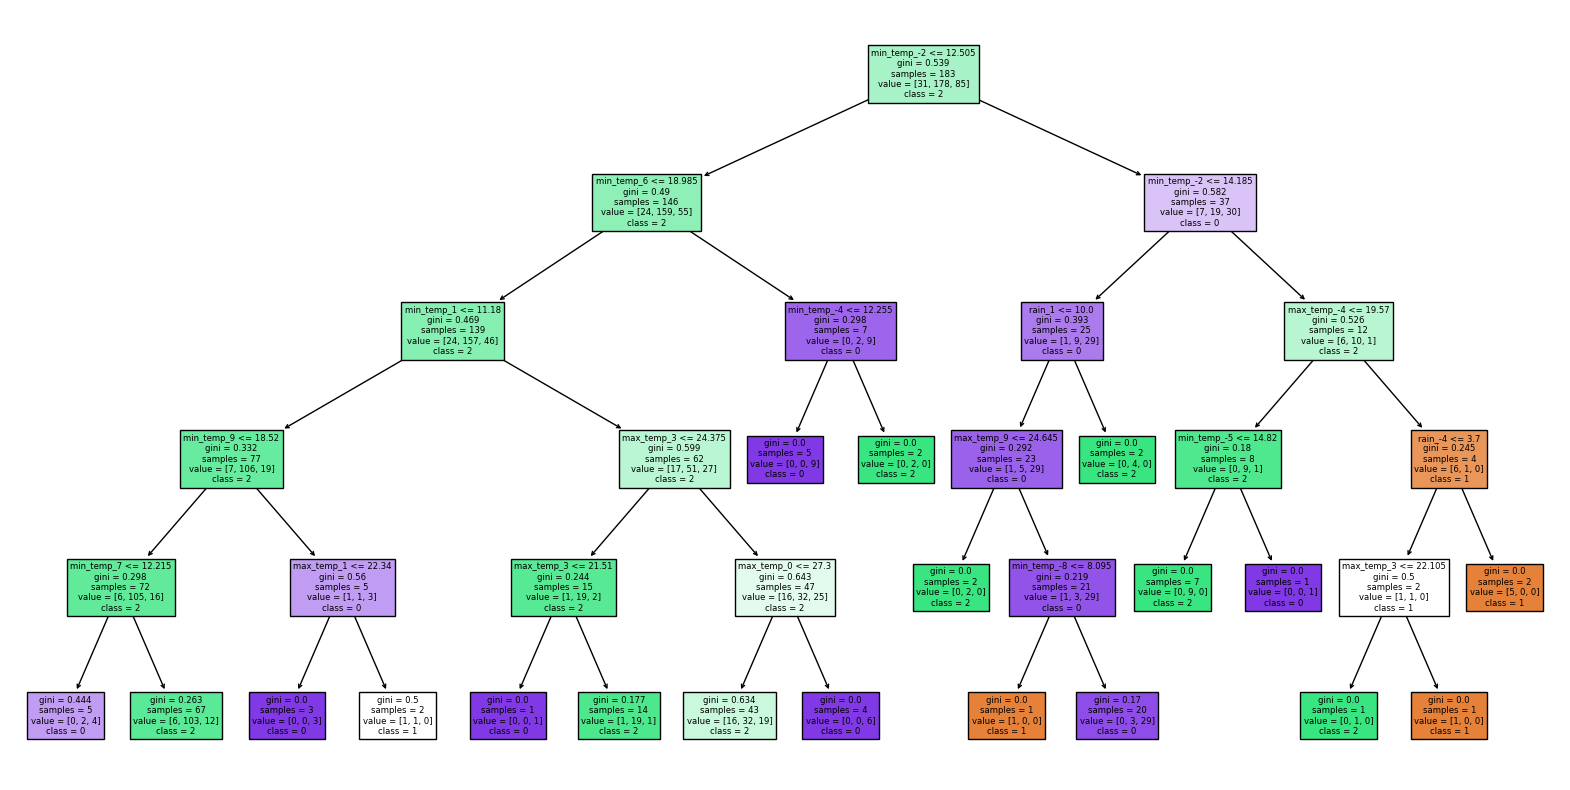


Information about each node in the first tree:
Internal node: Splitting on min_temp_-2 <= 12.505000114440918
  Internal node: Splitting on min_temp_6 <= 18.984999656677246
    Internal node: Splitting on min_temp_1 <= 11.179999828338623
      Internal node: Splitting on min_temp_9 <= 18.520000457763672
        Internal node: Splitting on min_temp_7 <= 12.21500015258789
          Leaf node: Predicted class - 0
          Leaf node: Predicted class - 2
        Internal node: Splitting on max_temp_1 <= 22.34000015258789
          Leaf node: Predicted class - 0
          Leaf node: Predicted class - 1
      Internal node: Splitting on max_temp_3 <= 24.375
        Internal node: Splitting on max_temp_3 <= 21.510000228881836
          Leaf node: Predicted class - 0
          Leaf node: Predicted class - 2
        Internal node: Splitting on max_temp_0 <= 27.300000190734863
          Leaf node: Predicted class - 2
          Leaf node: Predicted class - 0
    Internal node: Splitting on min_te

In [58]:
feature_names = list(X.columns)
class_names = [str(cls) for cls in y.unique()]

def print_tree_node(tree, feature_names, class_names, node_index = 0, indent = ""):
  node = tree.tree_
  if node.children_left[node_index] == node.children_right[node_index]:
    class_idx = node.value[node_index].argmax()
    class_name = class_names[class_idx]
    print(f"{indent}Leaf node: Predicted class - {class_name}")

  else:
    feature_idx = node.feature[node_index]
    threshold = node.threshold[node_index]
    feature_name = feature_names[feature_idx]
    print(f"{indent}Internal node: Splitting on {feature_name} <= {threshold}")

    print_tree_node(tree, feature_names, class_names, node.children_left[node_index], indent + "  ")
    print_tree_node(tree, feature_names, class_names, node.children_right[node_index], indent + "  ")

plt.figure(figsize = (20, 10))
plot_tree(rf_model.estimators_[0], feature_names=feature_names, class_names=class_names, filled = True)
plt.show()

print("\nInformation about each node in the first tree:")
print_tree_node(rf_model.estimators_[0], feature_names, class_names)


In [59]:
feature_importances = rf_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

print("\nTop 20 Feature Importances:")
for idx in sorted_indices[:20]:
  print(f"{X.columns[idx]}: {feature_importances[idx]:.4f}")



Top 20 Feature Importances:
min_temp_-6: 0.0491
min_temp_-2: 0.0338
rain_-7: 0.0333
max_temp_-2: 0.0331
rain_-3: 0.0316
max_temp_3: 0.0253
min_temp_-5: 0.0243
min_temp_3: 0.0240
max_temp_-7: 0.0232
max_temp_0: 0.0230
min_temp_1: 0.0230
max_temp_8: 0.0225
max_temp_1: 0.0224
min_temp_-3: 0.0220
min_temp_-7: 0.0220
rain_-1: 0.0213
max_temp_-1: 0.0213
max_temp_-5: 0.0211
max_temp_2: 0.0210
rain_-2: 0.0209


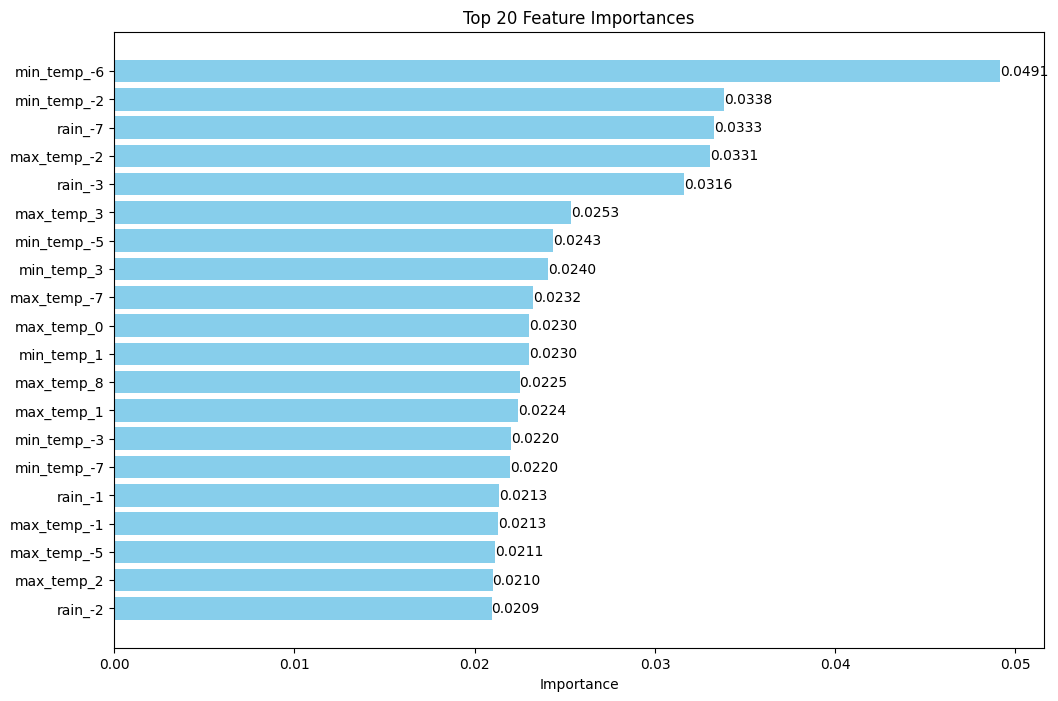

In [60]:
top_n = 20
top_indices = sorted_indices[:top_n]
top_features = [X.columns[idx] for idx in top_indices]
top_importances = feature_importances[top_indices]

plt.figure(figsize = (12, 8))
bars = plt.barh(top_features, top_importances, color = 'skyblue')

for bar, importance in zip(bars, top_importances):
  plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{importance:.4f}', va = 'center', ha = 'left')

plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis() # invert y axis to show the most important feature at the top
plt.show()


##Logistic Regression

In [61]:
# # top features by class and magnitude

# for class_label in range(lr_model.coef_.shape[0]):
#   print(f"Class {class_label} Top 20 Feature Coefficients:")
#   coefficients = lr_model.coef_[class_label] # coefficients for the current class
#   sorted_indices = np.argsort(np.abs(coefficients))[::-1]
#   for idx in sorted_indices[:20]:
#     print(f"{X.columns[idx]}: {coefficients[idx]:.4f}")
#   print()



Class 0 Top 20 Feature Coefficients:
min_temp_1: 1.1821
min_temp_0: 1.0569
min_temp_-7: -1.0006
min_temp_-8: -0.8514
min_temp_-3: 0.7654
min_temp_9: -0.7606
rain_7: -0.7347
rain_8: -0.7115
max_temp_2: -0.7110
min_temp_-4: -0.7041
min_temp_8: -0.6866
min_temp_-2: 0.5561
max_temp_9: 0.5335
max_temp_-4: -0.4743
max_temp_6: -0.4450
max_temp_-7: 0.4313
max_temp_-5: -0.3859
min_temp_5: 0.3727
max_temp_1: 0.3338
max_temp_5: 0.3286



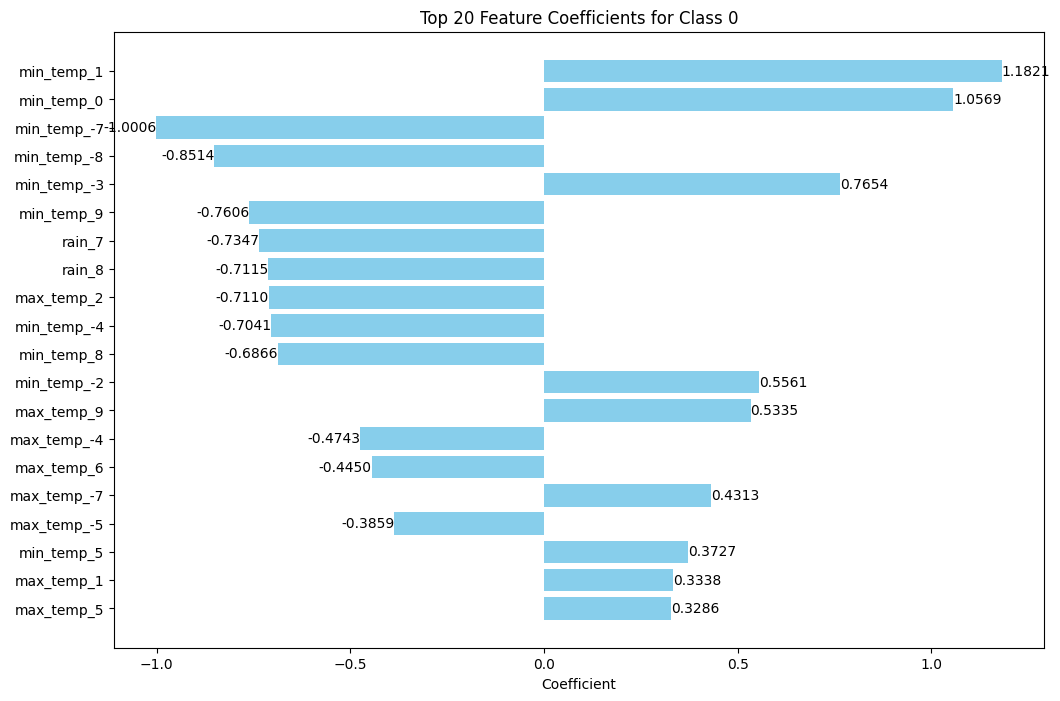


Class 1 Top 20 Feature Coefficients:
min_temp_9: 0.7205
max_temp_0: -0.4708
min_temp_-1: -0.4182
min_temp_1: -0.3653
max_temp_-5: 0.3112
min_temp_-6: 0.3054
min_temp_-8: 0.2526
max_temp_-1: 0.2260
max_temp_5: -0.2219
rain_7: 0.2215
max_temp_-6: -0.2211
max_temp_2: 0.2161
max_temp_6: 0.2099
max_temp_9: -0.2062
min_temp_6: -0.1971
max_temp_-2: -0.1953
min_temp_-4: 0.1868
min_temp_7: -0.1756
min_temp_4: -0.1676
max_temp_-3: 0.1619



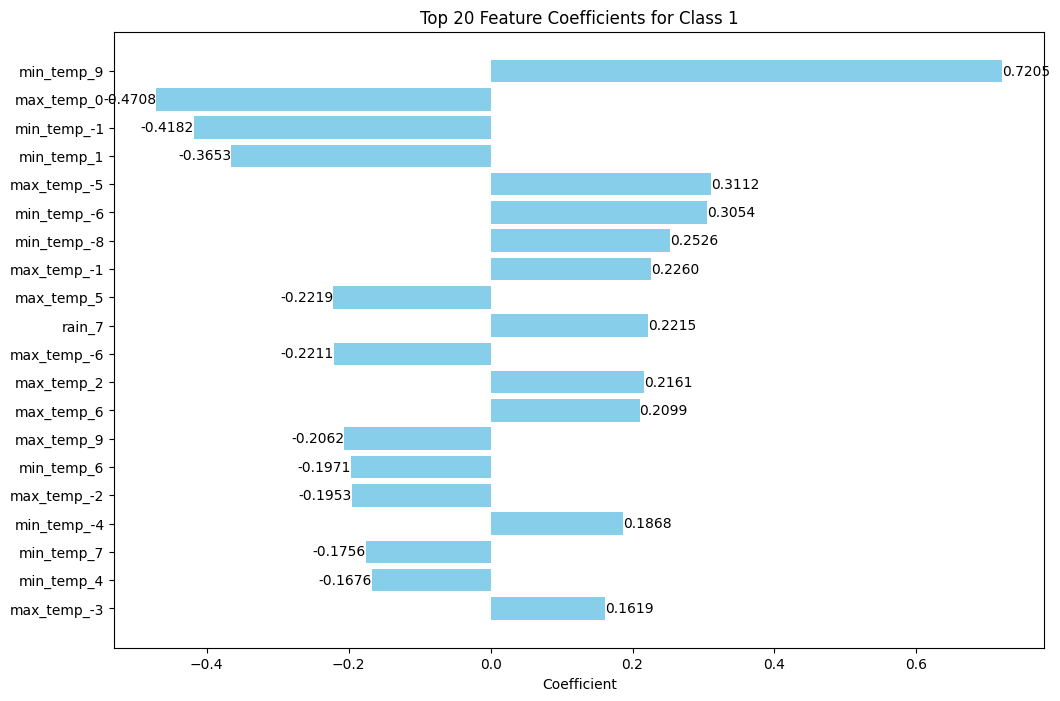


Class 2 Top 20 Feature Coefficients:
min_temp_9: -0.5789
max_temp_0: 0.5371
min_temp_-1: 0.3571
min_temp_-7: 0.3253
min_temp_-6: -0.3239
max_temp_-5: -0.3158
max_temp_-6: 0.3131
min_temp_6: 0.2646
min_temp_-2: -0.2313
min_temp_0: -0.2122
max_temp_-1: -0.2096
max_temp_6: -0.2015
min_temp_-5: -0.2013
max_temp_-2: 0.1966
min_temp_5: 0.1964
min_temp_-3: -0.1947
min_temp_-8: 0.1856
max_temp_3: -0.1730
max_temp_8: -0.1666
max_temp_5: 0.1549



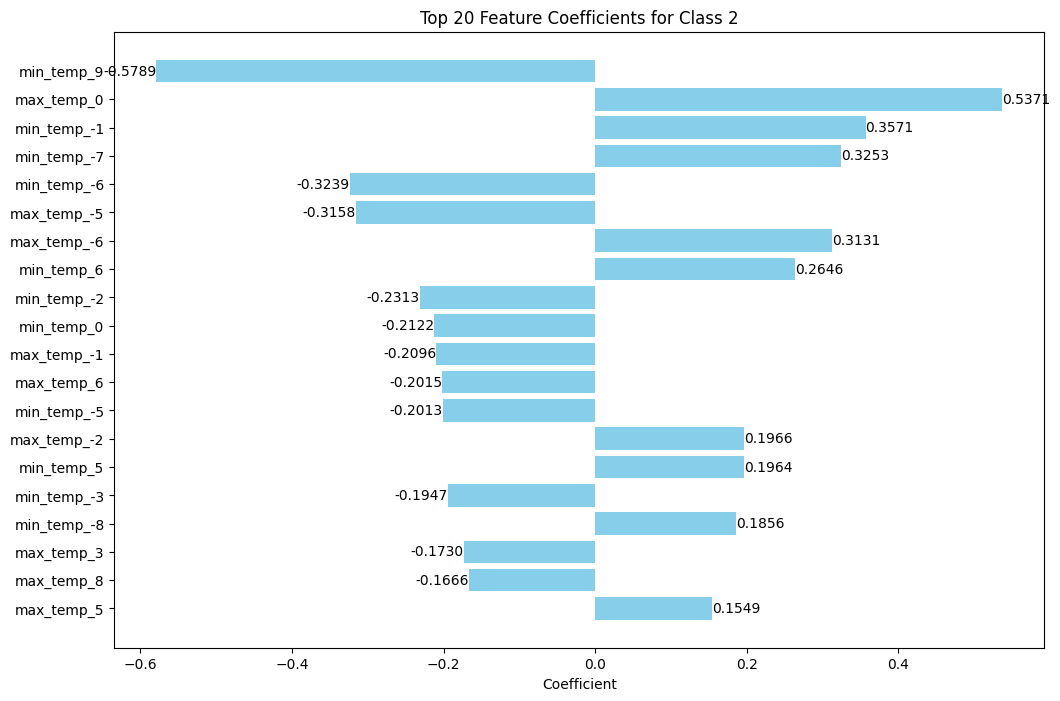

In [62]:
num_classes = lr_model.coef_.shape[0]

for class_label in range(num_classes):
  print(f"\nClass {class_label} Top 20 Feature Coefficients:")

  coefficients = lr_model.coef_[class_label]
  sorted_indices = np.argsort(np.abs(coefficients))[::-1]
  top_n = 20
  top_indices = sorted_indices[:top_n]
  top_features = [X.columns[idx] for idx in top_indices]
  top_coefficients = coefficients[top_indices]

  # print the top 20 features and their coefficients
  for idx in top_indices:
    print(f"{X.columns[idx]}: {coefficients[idx]:.4f}")
  print()

  # create a horizontal bar chart
  plt.figure(figsize = (12, 8))
  bars = plt.barh(top_features, top_coefficients, color = 'skyblue')

  # add coefficient value labels to each bar
  for bar, coeff in zip(bars, top_coefficients):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{coeff:.4f}', va = 'center', ha = 'left' if coeff > 0 else 'right')

  plt.xlabel('Coefficient')
  plt.title(f'Top 20 Feature Coefficients for Class {class_label}')
  plt.gca().invert_yaxis()
  plt.show()


In [63]:
coefficients = lr_model.coef_
intercepts = lr_model.intercept_
classes = np.unique(y)
variable_names = X.columns

equations = []
for i, class_label in enumerate(classes):
  equation = f"Logit(P(y={class_label} | x)) = "
  equation += " + ".join([f"{coeff:.4f} * {var}" for coeff, var in zip(coefficients[i], variable_names)])
  equation += f" + {intercepts[i]:.4f}"
  equations.append(equation)

print("Logistic Regression Equations:")
for i, equation in enumerate(equations):
  print(f"Class {classes[i]}: {equation}")


Logistic Regression Equations:
Class 0: Logit(P(y=0 | x)) = 0.0184 * rain_-8 + 0.0219 * rain_-7 + 0.0021 * rain_-6 + -0.0023 * rain_-5 + -0.0055 * rain_-4 + -0.0149 * rain_-3 + -0.0810 * rain_-2 + -0.2104 * rain_-1 + 0.0814 * rain_0 + 0.0930 * rain_1 + -0.0513 * rain_2 + -0.0707 * rain_3 + -0.1791 * rain_4 + -0.0172 * rain_5 + 0.0829 * rain_6 + -0.7347 * rain_7 + -0.7115 * rain_8 + -0.2189 * max_temp_-8 + 0.4313 * max_temp_-7 + -0.1683 * max_temp_-6 + -0.3859 * max_temp_-5 + -0.4743 * max_temp_-4 + -0.2564 * max_temp_-3 + 0.1070 * max_temp_-2 + 0.2025 * max_temp_-1 + 0.3142 * max_temp_0 + 0.3338 * max_temp_1 + -0.7110 * max_temp_2 + 0.0945 * max_temp_3 + -0.2418 * max_temp_4 + 0.3286 * max_temp_5 + -0.4450 * max_temp_6 + 0.2553 * max_temp_7 + -0.1240 * max_temp_8 + 0.5335 * max_temp_9 + -0.8514 * min_temp_-8 + -1.0006 * min_temp_-7 + -0.2483 * min_temp_-6 + 0.0434 * min_temp_-5 + -0.7041 * min_temp_-4 + 0.7654 * min_temp_-3 + 0.5561 * min_temp_-2 + 0.1432 * min_temp_-1 + 1.0569 * min_t